In [3]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from MIOFlow.losses import density_specified_OT_loss
from MIOFlow.utils import kde


In [2]:
n1 = 20  # nb samples
n2 = 20  # nb samples
n12 = 20  # nb samples

mu_s = np.array([-1, -1])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([-1, -1])
cov_t = np.array([[1, 0], [0, 1]])

mu_s2 = np.array([4, 4])
cov_s2 = np.array([[1, 0], [0, 1]])

np.random.seed(0)
xs = ot.datasets.make_2D_samples_gauss(n1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n2, mu_t, cov_t)
xs2 = ot.datasets.make_2D_samples_gauss(n12, mu_s2, cov_s2)

xs = np.concatenate((xs, xs2), axis=0)

n_noise = 0

xs = np.concatenate((xs, ((np.random.rand(n_noise, 2) - 4))), axis=0)
xt = np.concatenate((xt, ((np.random.rand(n_noise, 2) + 6))), axis=0)

xs = torch.tensor(xs, dtype=torch.float32, requires_grad=True)
xt = torch.tensor(xt, dtype=torch.float32, requires_grad=False)

n1 = n1 + n12 + n_noise
n2 = n2 + n_noise

a, b = np.ones((n1,)), np.ones((n2,))  # uniform distribution on samples

a = torch.tensor(a, dtype=torch.float32, requires_grad=True)
b = torch.tensor(b, dtype=torch.float32, requires_grad=True)

# loss matrix
# M = ot.dist(xs, xt)
M = torch.cdist(xs, xt)
# M /= M.max()



In [7]:
p1 = kde(xt)
log1 = torch.log(p1)
m1 = (log1 - log1.mean())

In [17]:
reg = 0.005
reg_m_kl = 0.05
reg_m_l2 = 5
mass = 0.7

# loss = ot.unbalanced.mm_unbalanced2(a, b, M, reg_m_kl, div='kl')
# loss = ot.emd2(a, b, M)
# loss = ot.sinkhorn2(a, b, M, 0.5, verbose=False)
loss_func = density_specified_OT_loss(reg=0.5, take_softmax=True)
loss = loss_func(xs, xt, a, m1)
Gs = ot.sinkhorn(a, p1, M, 0.5, verbose=False)
# loss = ot.unbalanced.sinkhorn_unbalanced2(a, b, M, reg, reg_m_kl)
# Gs = ot.unbalanced.sinkhorn_knopp_unbalanced(a, b, M, reg, reg_m_kl)
# loss = (Gs * M).sum()
loss.backward()
# emd_ot = ot.emd(a, b, M)
# entropic_kl_uot = ot.unbalanced.sinkhorn_unbalanced(a, b, M, reg, reg_m_kl)
# kl_uot = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_kl, div='kl')
# l2_uot = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_l2, div='l2')

/Users/xingzhi/micromamba/envs/dmae/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 27
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


In [18]:
loss

tensor(4.9026, grad_fn=<SumBackward0>)

In [19]:
grads0 = a.grad.detach().numpy()

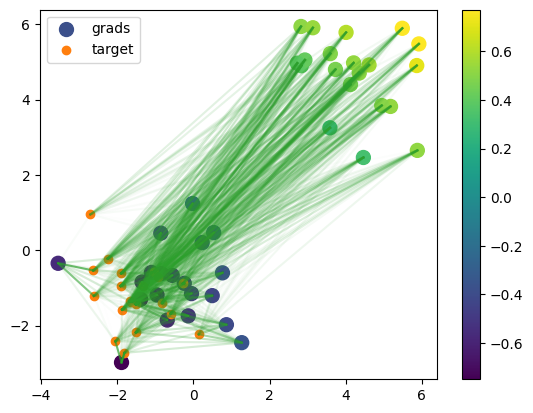

([], [])

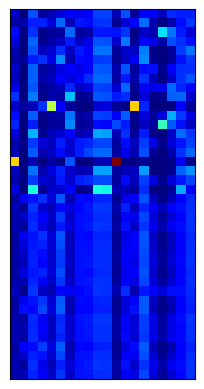

In [20]:
grads = grads0
xs = xs.detach()
xt = xt.detach()
P = Gs.detach().numpy()
if P.sum() > 0:
    P = P / P.max()
for i in range(n1):
    for j in range(n2):
        if P[i, j] > 0:
            pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]], color='C2',
                    alpha=P[i, j])
# pl.scatter(xs[:, 0], xs[:, 1], c='C0', alpha=1, label='source')
scatter = pl.scatter(xs[:, 0], xs[:, 1], c=grads, alpha=1, s=100, label='grads')
pl.scatter(xt[:, 0], xt[:, 1], c='C1', alpha=1, label='target')
pl.legend()
pl.colorbar(scatter)
pl.show()
# pl.scatter(xs[:, 0], xs[:, 1], c='C0', s=P.sum(1).ravel() * (1 + p) * 2)
# pl.scatter(xt[:, 0], xt[:, 1], c='C1', s=P.sum(0).ravel() * (1 + p) * 2)
pl.yticks(())
pl.xticks(())
pl.imshow(P, cmap='jet')
pl.yticks(())
pl.xticks(())